# Model

At this point, we have collected, cleaned and prepared our data. We are now ready to start training the machine learning model which will be used to predict which of the new videos on [Youtube](https://www.youtube.com), related to artificial intelligence, machine learning and deep learning, are appealing to my taste.

In this notebook, we will compare the performance of three classifiers: Random Forest, LightGBM and Logistic Regression.

## Importing data

In [1]:
import pandas as pd                                                # handles dataframes
import numpy as np                                                 # performs math operations
from sklearn.feature_extraction.text import TfidfVectorizer        # assign numerical values to text
from scipy.sparse import hstack, vstack                            # stacks sparse matrices
from sklearn.model_selection import train_test_split               # splits datasets
from sklearn.linear_model import LogisticRegression                # logistic regression classifier
from sklearn.ensemble import RandomForestClassifier                # random forest classifier
from lightgbm import LGBMClassifier                                # lightGBM classificer
from sklearn.metrics import roc_auc_score, average_precision_score # metrics
from skopt import forest_minimize                                  # forest minimizer
from sklearn.preprocessing import MaxAbsScaler, StandardScaler     # for scaling and normalization
from scipy.sparse import csr_matrix                                # converts dense to sparse matrix and vice versa
from sklearn.pipeline import make_pipeline                         # constructs a pipeline
from sklearn.model_selection import GridSearchCV                   # finds best parameters
import matplotlib.pyplot as plt                                    # plots data

In [2]:
# Importing data:
df = pd.read_csv("train.csv", index_col=0).dropna(subset=["y"])
df.shape, df.columns

((1393, 7),
 Index(['categ', 'duration', 'views', 'like_ratio', 'channel_appeal', 'title',
        'y'],
       dtype='object'))

In [3]:
print('Positive examples: ',len(df[df['y']==1]))
print('Negative examples: ',len(df[df['y']==0]))

Positive examples:  462
Negative examples:  931


In the following, we define the training and test datasets as well as transform the text entries for 'title' into numbers. For that, we use scikitlearn's function [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to transform the text entries of the 'title' feature into numerical values which can be used to train the model. This function gives a higher weight to words that appear more frequently in a given example whereas that word is not very common in the entire dataset.

The argument *min-df* is the minimum number which a word has to appear in the text (in this case, the video title) in order to be accounted for. The argument *max_features* limits the number of word contained in the vocabulary, ordered by word frequency. The argument *ngram_range(i,j)*, in turn, is related to the combinations of words: "i" the minimum number of words that the sequential combination will have, while "j" is the maximum number of words contained in a sequential combination. For instance, if the video has the title "How to master machine learning", we will have these situations:<br>
ngram_range(1,1): "How", "to", "master", "machine", "learning"<br>
ngram_range(1,2): "How", "to", "master", "machine", "learning", "How to", "to master", "master machine", " machine learning"<br>
ngram_range(2,2): "How to", "to master", "master machine", " machine learning"

In [4]:
X = df.drop(['y'],axis=1).copy() # input training set
y = df['y'].copy()               # output training set

# Training and test sets:
Xtr, Xtest, ytr, ytest = train_test_split(X,y,test_size=0.3,random_state=0)
print("Before transforming 'title': ",Xtr.shape, Xtest.shape, ytr.shape, ytest.shape)

# Function to transform title into numerical values:
def Title_bow(Xtr,Xtest,min_df,ngram_range,max_features=None):
    title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range,max_features=max_features)
    title_bow_tr = title_vec.fit_transform(Xtr['title']) 
    title_bow_test = title_vec.transform(Xtest['title'])
    return title_bow_tr, title_bow_test

# Let's see how introducing the vectorized title features would change the dataset:
title_bow_tr, title_bow_test = Title_bow(Xtr,Xtest,2,(1,1),400)
Xtr  = hstack([Xtr.drop(['title'],axis=1), title_bow_tr])
Xtest = hstack([Xtest.drop(['title'],axis=1), title_bow_test])
print("After transforming 'title': ",Xtr.shape, Xtest.shape, ytr.shape, ytest.shape)

Before transforming 'title':  (975, 6) (418, 6) (975,) (418,)
After transforming 'title':  (975, 405) (418, 405) (975,) (418,)


## Random Forest

The [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is the first model that we are going to train. In this section, we will be investigating the possible choices for the parameters that will lead to the best performance of the model.

First let us see how the Random Forest classifier performs without tuning its parameters:

In [5]:
# Non-optimal Random Forest:
clf_RF = RandomForestClassifier(class_weight="balanced", n_jobs=4, random_state=0)
clf_RF.fit(Xtr, ytr)
p = clf_RF.predict_proba(Xtest)[:,1]   # prediction array
ap = average_precision_score(ytest, p) # average precision score
auc = roc_auc_score(ytest, p)          # area under the curve score

print('{:<10}  {}'.format('AP:',round(ap,4)))
print('{:<10}  {}'.format('AUC:',round(auc,4)))
print('{:<10}  {}'.format('Train acc:',round(clf_RF.score(Xtr,ytr),4)))
print('{:<10}  {}'.format('Test acc:',round(clf_RF.score(Xtest,ytest),4)))

AP:         0.6631
AUC:        0.8161
Train acc:  0.9959
Test acc:   0.744


The results above show that this classifier is clearly overfitting. We can improve that by tuninng the parameters, as follows.

#### GridSearch

We now explore the best parameters for the Random Forest model using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from sklearn. In the function explore_RF defined below, we investigate how the model improves when we change the number of maximum features in TfidfVectorizer, more specifically the function Title_bow defined at the end of the previous section, while we simultaneously search for optimal parameters for the Random Forest classifier.

The primary metric used for the optimization process is the average precision, while the secondary is the area under the ROC curve. Those metrics are preferable in comparison to accuracy because our data are unbalanced, since the number of negative examples is approximately the double of the positive ones.

In [6]:
# Random Forest parameters to be optimized:
n_estimators = [300]               # Number of trees in the random forest
max_features = ['auto','sqrt']     # Number of features to consider at every split
max_depth = [6,8]                  # Maximum number of levels in tree
min_samples_split = [5,10]         # Minimum number of samples required to split a node
min_samples_leaf = [1,2]           # Minimum number of samples required at each leaf node
max_leaf_nodes = [None]            # Grow trees with max_leaf_nodes in best-first fashion

# Creating the parameter grid:
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_leaf_nodes': max_leaf_nodes}

def explore_RF(param_grid, max_feat, num_loops):
    """
    Returns the scores for the train and the test performance metrics,
    the max_features that were used and the best parameters
    found by the GridSearch for the Random Forest classifier.
    
    param_grid: Random Forest parameter grid;
    max_feat: TfidfVectorizer max_features;
    num_loops: number of times the scores will be computed.
    """
    train_ap = [];     test_ap  = [];
    train_auc = [];    test_auc = [];
    train_acc = [];    test_acc = [];
    num_max_feat = []; best_param = []   
    for i in range(num_loops):
        # Vectorizing titles:
        Xtr, Xtest, ytr, ytest = train_test_split(X,y,test_size=0.4,random_state=0)
        title_bow_tr, title_bow_test = Title_bow(Xtr,Xtest,2,(1,1), max_feat+(10*i) )
        Xtr  = hstack([Xtr.drop(['title'],axis=1), title_bow_tr])
        Xtest = hstack([Xtest.drop(['title'],axis=1), title_bow_test])
    
        # Model:
        rf_Model = RandomForestClassifier(class_weight="balanced")
        rf_Grid = GridSearchCV(estimator=rf_Model,param_grid=param_grid,scoring='average_precision',cv=4,n_jobs=4)
        rf_Grid.fit(Xtr, ytr)
        clf_RF = rf_Grid.best_estimator_
        
        # Probability of predicting that a video is appealing:
        p_tr = clf_RF.predict_proba(Xtr)[:,1]
        p_test = clf_RF.predict_proba(Xtest)[:,1]
        
        # Results:
        train_ap.append(average_precision_score(ytr, p_tr))     
        test_ap.append(average_precision_score(ytest, p_test))
        train_auc.append(roc_auc_score(ytr, p_tr))
        test_auc.append(roc_auc_score(ytest, p_test))
        train_acc.append(clf_RF.score(Xtr,ytr))
        test_acc.append(clf_RF.score(Xtest,ytest))
        num_max_feat.append( max_feat+(10*i) )
        best_param.append(rf_Grid.best_params_)
    return train_ap, test_ap, train_auc, test_auc, train_acc, test_acc, num_max_feat, best_param

train_ap,test_ap, train_auc,test_auc, train_acc,test_acc, num_max_feat,best_param = explore_RF(param_grid, 10, 50)

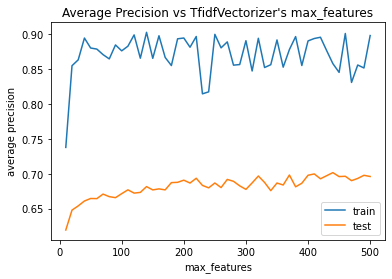

In [7]:
# Plotting average precision values
plt.plot(num_max_feat,train_ap,label='train'); plt.plot(num_max_feat,test_ap,label='test'); plt.legend();
plt.xlabel('max_features'); plt.ylabel('average precision');
plt.title("Average Precision vs TfidfVectorizer's max_features");

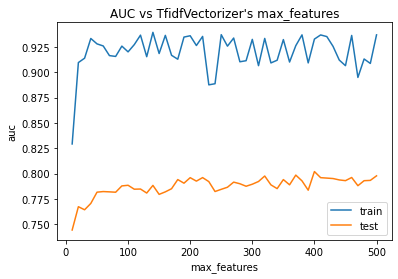

In [8]:
# Plotting area under the roc curve values
plt.plot(num_max_feat,train_auc,label='train'); plt.plot(num_max_feat,test_auc,label='test'); plt.legend();
plt.xlabel('max_features'); plt.ylabel('auc');
plt.title("AUC vs TfidfVectorizer's max_features");

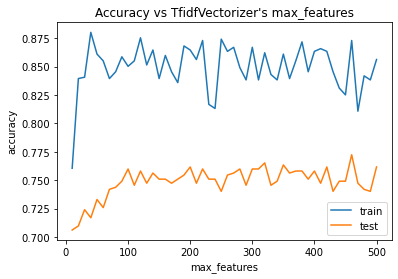

In [9]:
# Plotting accuracy values
plt.plot(num_max_feat,train_acc,label='train'); plt.plot(num_max_feat,test_acc,label='test'); plt.legend();
plt.xlabel('max_features'); plt.ylabel('accuracy');
plt.title("Accuracy vs TfidfVectorizer's max_features");

In all the three graphs above we see that by adding the vectorized title features to the dataset we improve all the metrics. The average precision for the test dataset, which is the most important metric to evaluate the performance of our model, stabilizes around max_features=400. The metrics AUC and accuracy behave similarly. The high oscilation in the curves of the graphics above is related to the number of trees chosen in order to speed up the grid search, which was n_estimators=300. 

#### Fitted Random Forest Model

In the following, we will train the random forest model with the best parameters associated with TfidfVectorizer's max_features=400, but increasing the number of trees to 1000 to get more stable predictions. Also, regarding the title vectorizer Title_bow, we use min_df=2 instead of min_df=1 or even min_df=3 because it slightly improves the scores, as I have manually verified that. Same thing for the choice of ngram_range=(1,1).

In [10]:
num_max_feat[39], best_param[39]

(400,
 {'max_depth': 8,
  'max_features': 'auto',
  'max_leaf_nodes': None,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 300})

In [11]:
# Using title vectorizer with the good choice for max_features:
Xtr, Xtest, ytr, ytest = train_test_split(X,y,test_size=0.4,random_state=0)
title_bow_tr, title_bow_test = Title_bow(Xtr,Xtest,2,(1,1), 400 )
Xtr  = hstack([Xtr.drop(['title'],axis=1), title_bow_tr])
Xtest = hstack([Xtest.drop(['title'],axis=1), title_bow_test])

# Random Forest fitted parameters and higher number of trees:
n_estimators =      1000
max_features =      best_param[39]['max_features']
max_depth =         best_param[39]['max_depth']
min_samples_split = best_param[39]['min_samples_split']
min_samples_leaf =  best_param[39]['min_samples_leaf']
max_leaf_nodes =    best_param[39]['max_leaf_nodes']

# Optimal Random Forest model:
clf_RF = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                max_leaf_nodes=None, class_weight="balanced", n_jobs=4, random_state=0)
clf_RF.fit(Xtr, ytr)
p = clf_RF.predict_proba(Xtest)[:,1]   # prediction array
ap = average_precision_score(ytest, p) # average precision score
auc = roc_auc_score(ytest, p)          # area under the curve score

print('{:<10}  {}'.format('AP:',round(ap,4)))
print('{:<10}  {}'.format('AUC:',round(auc,4)))
print('{:<10}  {}'.format('Train acc:',round(clf_RF.score(Xtr,ytr),4)))
print('{:<10}  {}'.format('Test acc:',round(clf_RF.score(Xtest,ytest),4)))

AP:         0.701
AUC:        0.8003
Train acc:  0.8683
Test acc:   0.7563


When we compare the results above to the ones computed in the begining of this section, we realize that by tuning the parameters we have substantially improved the average precision while we have also managed to control the overfitting problem.

# LightGBM

The next model to be checked is the [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html). Let us see if it gives us better results than Random Forest's. We will start by looking at LightGBM scores without tuning the parameters to see how the classifier performs:

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
# Model without tuning parameters:
clf_LGBM = LGBMClassifier(random_state=0, class_weight="balanced", n_jobs=4)
clf_LGBM.fit(Xtr, ytr)
p = clf_LGBM.predict_proba(Xtest)[:, 1]
ap = average_precision_score(ytest, p)
auc = roc_auc_score(ytest, p)
print('{:<10}  {}'.format('AP:',round(ap,4)))
print('{:<10}  {}'.format('AUC:',round(auc,4)))
print('{:<10}  {}'.format('Train acc:',round(clf_LGBM.score(Xtr,ytr),4)))
print('{:<10}  {}'.format('Test acc:',round(clf_LGBM.score(Xtest,ytest),4)))

AP:         0.6255
AUC:        0.7777
Train acc:  0.9832
Test acc:   0.733


The only metric that is higher compared to the Random Forest model is the train accuracy, which is most likely due to overfitting. Let us see if by tuning the parameters we can improve the LightGBM scores, and possibily make it beat the Random Forest model.

#### Bayesian Optimization

In [14]:
def tune_lgbm(param_grid):  #,Xtr,ytr,Xtest,ytest
    learning_rate     = param_grid[0]
    max_depth         = param_grid[1]
    min_child_samples = param_grid[2]
    subsample         = param_grid[3]
    colsample_bytree  = param_grid[4]
    n_estimators      = param_grid[5]
    min_df            = param_grid[6]
    max_feat          = param_grid[7]
    
    # title vectorizer:
    Xtr, Xtest, ytr, ytest = train_test_split(X,y,test_size=0.4,random_state=0)
    title_bow_tr, title_bow_test = Title_bow(Xtr,Xtest,min_df,(1,1), max_feat )
    Xtr  = hstack([Xtr.drop(['title'],axis=1), title_bow_tr])
    Xtest = hstack([Xtest.drop(['title'],axis=1), title_bow_test])
    # model:
    clf_LGBM = LGBMClassifier(learning_rate=learning_rate, num_leaves=2 ** max_depth, max_depth=max_depth, 
                         min_child_samples=min_child_samples, subsample=subsample,
                         colsample_bytree=colsample_bytree, bagging_freq=1,n_estimators=n_estimators,
                         random_state=0, class_weight="balanced", n_jobs=6)
    clf_LGBM.fit(Xtr, ytr)
    # scores:
    p = clf_LGBM.predict_proba(Xtest)[:, 1]
    ap = average_precision_score(ytest, p)
    auc = roc_auc_score(ytest, p)         
    train_acc = clf_LGBM.score(Xtr,ytr)
    test_acc  = clf_LGBM.score(Xtest,ytest)
    
    metric = ap -0.2*(train_acc-test_acc) +0.3*test_acc
    return -metric

param_grid = [(1e-3, 1e-1, 'log-uniform'), # learning_rate
          (1, 8),                          # max_depth
          (1, 15),                         # min_child_samples
          (0.1, 1.),                       # subsample
          (0.1, 1.),                       # colsample_bytree
          (500,1000),                      # n_estimators
          (1,2),                           # min_df
          (150,420)]                       # max_feat
res = forest_minimize(tune_lgbm, param_grid, random_state=0, n_random_starts=50, n_calls=100)
best_params = res.x

# Let's use the optimized parameters:
learning_rate     = best_params[0]
max_depth         = best_params[1]
min_child_samples = best_params[2]
subsample         = best_params[3]
colsample_bytree  = best_params[4]
n_estimators      = best_params[5]

# Retraining the LightGBM model using optimized parameters:
clf_LGBM = LGBMClassifier(learning_rate=learning_rate, num_leaves=2 ** max_depth, max_depth=max_depth, 
                 min_child_samples=min_child_samples, subsample=subsample,
                 colsample_bytree=colsample_bytree, bagging_freq=1,n_estimators=n_estimators,
                 random_state=0, class_weight="balanced", n_jobs=6)
clf_LGBM.fit(Xtr, ytr)
p = clf_LGBM.predict_proba(Xtest)[:, 1]
ap = average_precision_score(ytest, p)
auc = roc_auc_score(ytest, p)     
print('{:<10}  {}'.format('AP:',round(ap,4)))
print('{:<10}  {}'.format('AUC:',round(auc,4)))
print('{:<10}  {}'.format('Train acc:',round(clf_LGBM.score(Xtr,ytr),4)))
print('{:<10}  {}'.format('Test acc:',round(clf_LGBM.score(Xtest,ytest),4)))

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging

In [15]:
best_params

[0.049308407922096606,
 2,
 11,
 0.871395369305673,
 0.7191742165364887,
 939,
 1,
 285]

In [16]:
# Let's use the optimized parameters:
learning_rate     = best_params[0]
max_depth         = best_params[1]
min_child_samples = best_params[2]
subsample         = best_params[3]
colsample_bytree  = best_params[4]
n_estimators      = 1000

# Using title vectorizer with the  good choice for max_features:
Xtr, Xtest, ytr, ytest = train_test_split(X,y,test_size=0.4,random_state=0)
title_bow_tr, title_bow_test = Title_bow(Xtr,Xtest,2,(1,1), 400 )
Xtr  = hstack([Xtr.drop(['title'],axis=1), title_bow_tr])
Xtest = hstack([Xtest.drop(['title'],axis=1), title_bow_test])

# Retraining the LightGBM model using optimized parameters:
clf_LGBM = LGBMClassifier(learning_rate=learning_rate, num_leaves=2 ** max_depth, max_depth=max_depth, 
                         min_child_samples=min_child_samples, subsample=subsample,
                         colsample_bytree=colsample_bytree, bagging_freq=1,n_estimators=n_estimators,
                         random_state=0, class_weight="balanced", n_jobs=6)
clf_LGBM.fit(Xtr, ytr)
p = clf_LGBM.predict_proba(Xtest)[:, 1]
ap = average_precision_score(ytest, p)
auc = roc_auc_score(ytest, p)     
print('{:<10}  {}'.format('AP:',round(ap,4)))
print('{:<10}  {}'.format('AUC:',round(auc,4)))
print('{:<10}  {}'.format('Train acc:',round(clf_LGBM.score(Xtr,ytr),4)))
print('{:<10}  {}'.format('Test acc:',round(clf_LGBM.score(Xtest,ytest),4)))

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
AP:         0.6895
AUC:        0.7931
Train acc:  0.8623
Test acc:   0.7455


The average precision has improved after tuning the parameters, but when compare to that of the Random Forest model it is not superior.

# Logistic Regression

At last, we will check how Logistic Regression classifier performs and see if it beats Random Forest, which is the best model so far.

First, we will use the StandardScaler(), which is the usual normalization by subtracting the mean and dividing by the standard deviation. But we need to use csr_matrix() (compressed sparse row matrix) to convert the sparse the columns (related to the videos titles) of the training dataset into dense columns. After done that, we can see how the model performs with this kind  of normalization.

In [17]:
# Standard Normalization:
scaler = StandardScaler()
Xtr2 = csr_matrix(Xtr.copy());   
Xtest2 = csr_matrix(Xtest.copy());

#Xtr2[:, :5] = scaler.fit_transform(Xtr2[:, :5].todense())
#Xtest2[:, :5] = scaler.transform(Xtest2[:, :5].todense())

Xtr2[:, :] = scaler.fit_transform(Xtr2[:, :].todense())
Xtest2[:, :] = scaler.transform(Xtest2[:, :].todense())

# Fitting model:
clf_LR = LogisticRegression(C=0.5,n_jobs=6, random_state=0)
clf_LR.fit(Xtr2, ytr)
# Evaluating model:
p = clf_LR.predict_proba(Xtest2)[:, 1]
average_precision_score(ytest, p), roc_auc_score(ytest, p)

(0.5852219186113436, 0.713146923519264)

In [18]:
# Maximum absolute scaling:
scaler = MaxAbsScaler()
Xtr2 = csr_matrix(Xtr.copy());   
Xtest2 = csr_matrix(Xtest.copy());

Xtr2[:, :] = scaler.fit_transform(Xtr2[:, :].todense())
Xtest2[:, :] = scaler.transform(Xtest2[:, :].todense())

# Fitting model:
clf_LR = LogisticRegression(C=0.5,n_jobs=6, random_state=0)
clf_LR.fit(Xtr2, ytr)
# Evaluating model:
p = clf_LR.predict_proba(Xtest2)[:, 1]
average_precision_score(ytest, p), roc_auc_score(ytest, p)

(0.6960182992525009, 0.7949468085106383)

**Observation:**

I noticed that when I normalize only the first five columns of the training set, which are that columns that are originally not sparse, the result I get for the ap and auc metrics are:<br>
StandardScaler(): (0.6624527465434212, 0.7749640598044854) <br>
MaxAbsScaler() :   (0.6799009901194846, 0.7850129384703853) <br>

But when I apply the normalization to the whole set, I get: <br>
StandardScaler(): (0.5852219186113436, 0.713146923519264) <br>
MaxAbsScaler() :  (0.6960182992525009, 0.7949468085106383)  <br>

MaxAbsScaler shows superior performance in comparison to StandardScaler, specially when we scale all columns of the dataset. Therefore, we will use MaxAbsScaler to train our Logistic Regression model, scaling all features of the dataset.

Next, we will try different values for the parameter C:

In [19]:
def explore_LR(C): 
    """Takes a list of values for the regularization parameter
    and returns the metrics scores related to each of the choices."""
    AP = []; AUC = []; tr_acc = []; ts_acc = [] 
    w = {0:1,1:1.4}                 
    for c in C:                  #solvers to test: 'newton-cg', 'lbfgs', 'sag', 'liblinear','elasticnet','l1','l2'
        clf_LR = LogisticRegression(C=c,n_jobs=6, random_state=0, class_weight=w,solver='liblinear');
        clf_LR.fit(Xtr2, ytr)
        p  = clf_LR.predict_proba(Xtest2)[:, 1]
        ap = average_precision_score(ytest, p)
        auc= roc_auc_score(ytest, p)
        train_acc = clf_LR.score(Xtr2,ytr)
        test_acc  = clf_LR.score(Xtest2,ytest)
        AP.append(ap); AUC.append(auc); tr_acc.append(train_acc); ts_acc.append(test_acc)
    return AP, AUC, tr_acc, ts_acc
C = [0.005,0.01,0.03,0.05,0.1,0.3,0.5,0.6,0.8,1,1.3,1.5,2,3]
AP, AUC, tr_acc, ts_acc = explore_LR(C)
max(AP), max(AUC)

(0.6993378745490225, 0.7977357676825761)

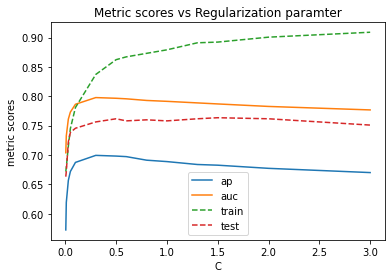

In [20]:
# Plotting metrics scores
plt.plot(C,AP,label='ap'); plt.plot(C,AUC,label='auc');
plt.plot(C,tr_acc,label='train',ls=('dashed'));plt.plot(C,ts_acc,label='test',ls=('dashed'));
plt.legend(); plt.xlabel('C'); plt.ylabel('metric scores'); plt.title("Metric scores vs Regularization paramter");

The only metric which continually rises when we increase the regularization parameter C is the training accuracy, which is related to an increasing overfitting. The other metrics start decline after C=0.3, approximately.

#### Fitted Logistic Regression

In [21]:
scaler = MaxAbsScaler()
Xtr2 = csr_matrix(Xtr.copy());   
Xtest2 = csr_matrix(Xtest.copy());
w = {0:1,1:1.4}
clf_LR = make_pipeline(scaler,LogisticRegression(C=0.3,n_jobs=6,random_state=0,class_weight=w,solver='liblinear'))
clf_LR.fit(Xtr2, ytr)

p_lr = clf_LR.predict_proba(Xtest2)[:, 1]
average_precision_score(ytest, p_lr), roc_auc_score(ytest, p_lr)

(0.6993378745490225, 0.7977357676825761)

The average precision and auc of Logistic Regression look slightly better than those of LightGBM, but it is inferior to those of Random Forest.

# Final Ensemble

Let's try to combine the models to see if we have a better prediction than that of individual classifiers.

In [22]:
# Training and test datasets:
Xtr, Xtest, ytr, ytest = train_test_split(X,y,test_size=0.4,random_state=0)
title_vec      = TfidfVectorizer(min_df=2, ngram_range=(1,1),max_features=400)
title_bow_tr   = title_vec.fit_transform(Xtr['title']) 
title_bow_test = title_vec.transform(Xtest['title'])

Xtr  = hstack([Xtr.drop(['title'],axis=1), title_bow_tr])
Xtest = hstack([Xtest.drop(['title'],axis=1), title_bow_test])

In [36]:
# RANDOM FOREST
n_estimators =      1000
max_features =      best_param[39]['max_features']
max_depth =         best_param[39]['max_depth']
min_samples_split = best_param[39]['min_samples_split']
min_samples_leaf =  best_param[39]['min_samples_leaf']
max_leaf_nodes =    best_param[39]['max_leaf_nodes']

clf_RF = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                max_leaf_nodes=None, class_weight="balanced", n_jobs=4, random_state=0)
clf_RF.fit(Xtr, ytr)
p_rf = clf_RF.predict_proba(Xtest)[:,1]

In [24]:
# LGBM
learning_rate     = best_params[0]
max_depth         = best_params[1]
min_child_samples = best_params[2]
subsample         = best_params[3]
colsample_bytree  = best_params[4]
n_estimators      = 1000
clf_LGBM = LGBMClassifier(learning_rate=learning_rate, num_leaves=2 ** max_depth, max_depth=max_depth, 
                         min_child_samples=min_child_samples, subsample=subsample,
                         colsample_bytree=colsample_bytree, bagging_freq=1,n_estimators=n_estimators,
                         random_state=0, class_weight="balanced", n_jobs=6)
clf_LGBM.fit(Xtr, ytr)
p_lgbm = clf_LGBM.predict_proba(Xtest)[:, 1]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [25]:
# LOGISTIC REGRESSION
scaler = MaxAbsScaler()
Xtr2 = csr_matrix(Xtr.copy());   
Xtest2 = csr_matrix(Xtest.copy());
w = {0:1,1:1.4}
clf_LR = make_pipeline(scaler,LogisticRegression(C=0.3,n_jobs=6,random_state=0,class_weight=w,solver='liblinear'))
clf_LR.fit(Xtr2, ytr)
p_lr = clf_LR.predict_proba(Xtest2)[:, 1]

In [37]:
# Let us take a look at how the models are correlated:
pd.DataFrame({"LR": p_lr, "RF": p_rf, "LGBM": p_lgbm}).corr()

,LR,RF,LGBM
LR,1.000000,0.893589,0.812261
RF,0.893589,1.000000,0.871611
LGBM,0.812261,0.871611,1.000000


#### Simple average

In [38]:
p = (p_lr + p_rf + p_lgbm)/3
average_precision_score(ytest, p), roc_auc_score(ytest, p)

(0.7176263347952183, 0.8098260494537091)

In [39]:
p = (p_lr + p_rf )/2
average_precision_score(ytest, p), roc_auc_score(ytest, p)

(0.7135711390447523, 0.8061313973548017)

In [40]:
p = (p_rf + p_lgbm )/2
average_precision_score(ytest, p), roc_auc_score(ytest, p)

(0.7080297340939422, 0.8006972397929845)

In [41]:
p = (p_lr + p_lgbm )/2
average_precision_score(ytest, p), roc_auc_score(ytest, p)

(0.7128903110684247, 0.8074252443933295)

As we already knew from the previous sections, Logistic Regression has a slightly worse performance in comparison to the other models. Still, the combination of all three models seems to be the best choice.

#### Weighted average

In [42]:
p = 0.2*p_lr + 0.4*p_rf + 0.4*p_lgbm
average_precision_score(ytest, p), roc_auc_score(ytest, p)

(0.7136426726484428, 0.8068789534215066)

In [43]:
p = 0.2*p_lr + 0.5*p_rf + 0.3*p_lgbm
average_precision_score(ytest, p), roc_auc_score(ytest, p)

(0.7167295147298323, 0.8092222541690626)

In [44]:
p = 0.4*p_lgbm + 0.6*p_rf
average_precision_score(ytest, p), roc_auc_score(ytest, p)

(0.7111201240303211, 0.8034861989649222)

In [45]:
p = 0.6*p_lgbm + 0.4*p_rf
average_precision_score(ytest, p), roc_auc_score(ytest, p)

(0.704621380532999, 0.7993027602070155)

In [46]:
p = 0.3*p_lr + 0.5*p_rf + 0.2*p_lgbm
average_precision_score(ytest, p), roc_auc_score(ytest, p)

(0.7194215394565769, 0.8120687176538239)

In [47]:
p = 0.4*p_lr + 0.6*p_rf
average_precision_score(ytest, p), roc_auc_score(ytest, p)

(0.7143124523441631, 0.8073533640023001)

In [48]:
p = 0.3*p_lr + 0.7*p_rf
average_precision_score(ytest, p), roc_auc_score(ytest, p)

(0.7150660889961689, 0.8079715353651523)

The weighted combination, with Logistic Regression, Random Forest and LightGBM having weights of 0.3, 0.5 and 0.2, respectively, provides us with the best scores for the average precision and the area under the ROC curve metrics. However, we still should take a look at how those classifiers will perform on new, unseen data before we build the web application to show the results of the project to the public. Check the notebook "Testing_Model_in_Production.ipynb" to see the conclusion.

# Saving trained models

We will now save our trained machine learning classifiers, as well as the title vectorizer, in order to use them in production.

In [51]:
import joblib as jb
jb.dump(clf_LGBM, "lgbm_2021.pkl.z")
jb.dump(clf_RF, "random_forest_2021.pkl.z")
jb.dump(clf_LR, "logistic_reg_2021.pkl.z")
jb.dump(title_vec, "title_vectorizer_2021.pkl.z")

['title_vectorizer_2021.pkl.z']